In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#### Data is taken from from https://www.kaggle.com/datasets/lambda21525702290303/solar-energy-prediction

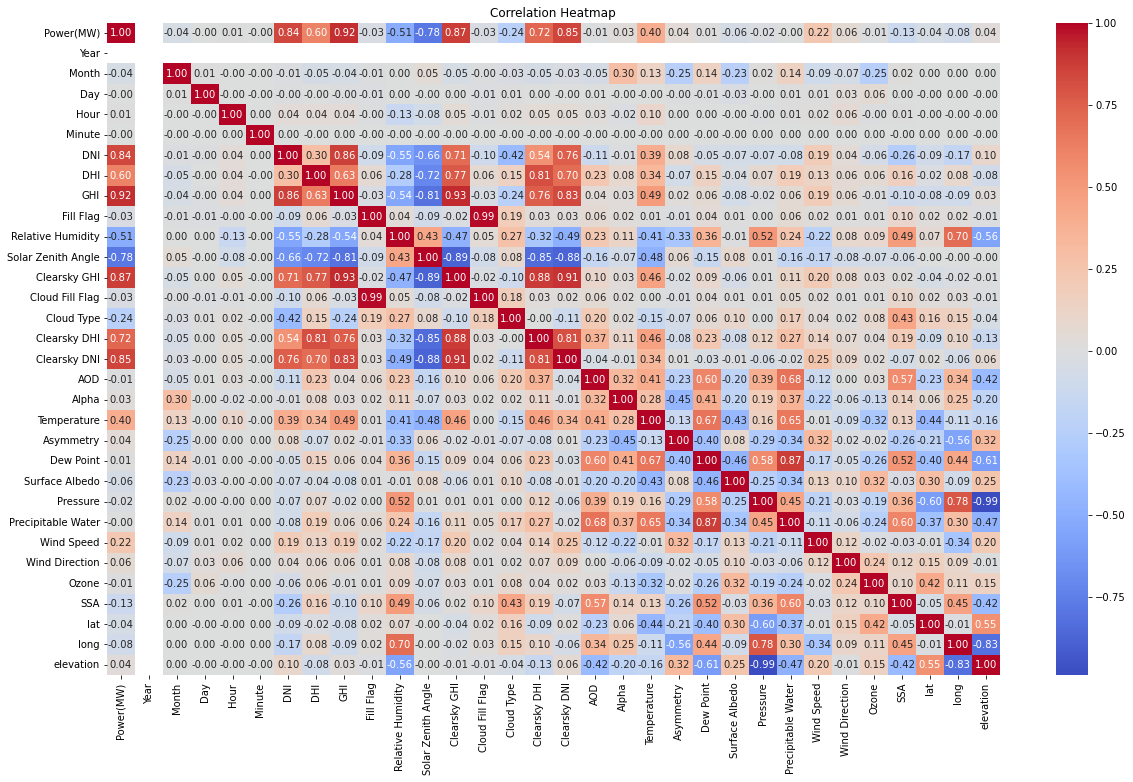

In [2]:
df_power = pd.read_csv('CleanTechData/usaWithWeather.csv')

# Compute correlation matrix
corr = df_power.corr()

# Plot heatmap
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()



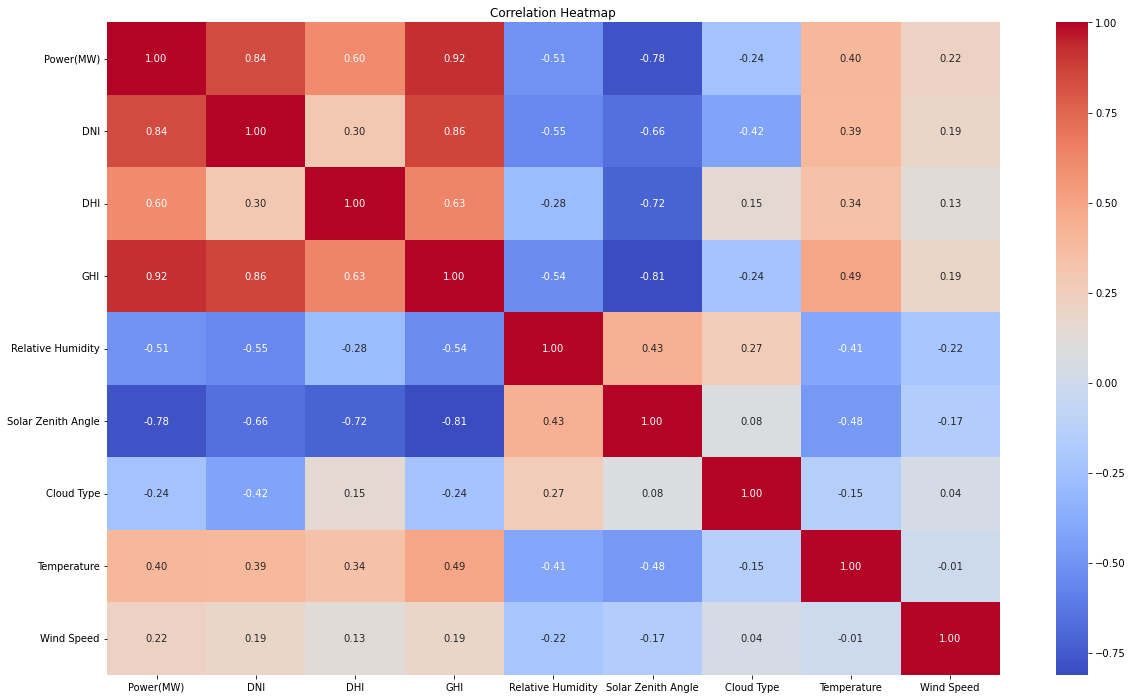

In [3]:
df_power_filtered = df_power[['LocalTime',	'Power(MW)', 'DNI',	'DHI',	'GHI', 'Relative Humidity', 'Solar Zenith Angle', 'Cloud Type', 'Temperature', 'Wind Speed']]

# Compute correlation matrix
corr = df_power_filtered.corr()

# Plot heatmap
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


In [5]:
df_power_filtered.head()

# Save datafarme to csv
df_power_filtered.to_csv("output.csv", index=False) 

In [ ]:
# Basic Dataset Information
# df_power_filtered.head()
print(df_power_filtered.shape)
df_power_filtered.info()
missing_values = df_power_filtered.isnull().sum()
print(missing_values)


(70080, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70080 entries, 0 to 70079
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LocalTime           70080 non-null  object 
 1   Power(MW)           70080 non-null  float64
 2   DNI                 70080 non-null  int64  
 3   DHI                 70080 non-null  int64  
 4   GHI                 70080 non-null  int64  
 5   Relative Humidity   70080 non-null  float64
 6   Solar Zenith Angle  70080 non-null  float64
 7   Cloud Type          70080 non-null  int64  
 8   Temperature         70080 non-null  float64
 9   Wind Speed          70080 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 5.3+ MB
LocalTime             0
Power(MW)             0
DNI                   0
DHI                   0
GHI                   0
Relative Humidity     0
Solar Zenith Angle    0
Cloud Type            0
Temperature           0
Wind Speed   

In [28]:
# Statistical summary 
df_power_filtered.describe()
df_power_filtered.corr()

df_power_filtered['LocalTime'] = pd.to_datetime(df_power_filtered['LocalTime'])

# Convert to numeric, coerce errors to NaN
df_power_filtered['Power(MW)'] = pd.to_numeric(df_power_filtered['Power(MW)'], errors='coerce')


# Get min and max
min_date = df_power_filtered['LocalTime'].min()
max_date = df_power_filtered['LocalTime'].max()

# Get difference
date_range = max_date - min_date

print(f"Date Range: {date_range}")


Date Range: 364 days 23:30:00


C:\Users\tania\AppData\Local\Temp/ipykernel_33924/4183759184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_power_filtered['LocalTime'] = pd.to_datetime(df_power_filtered['LocalTime'])
C:\Users\tania\AppData\Local\Temp/ipykernel_33924/4183759184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_power_filtered['Power(MW)'] = pd.to_numeric(df_power_filtered['Power(MW)'], errors='coerce')


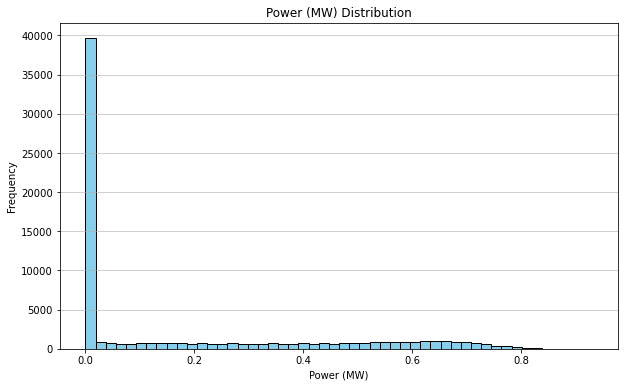

In [29]:
# Target Variable Analysis
plt.figure(figsize=(10,6))
plt.hist(df_power_filtered['Power(MW)'], bins=50, color='skyblue', edgecolor='black')
plt.title('Power (MW) Distribution')
plt.xlabel('Power (MW)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()



In [34]:
min_power = df_power_filtered['Power(MW)'].min()
max_power = df_power_filtered['Power(MW)'].max()
mean_power = df_power_filtered['Power(MW)'].mean()
std_power = df_power_filtered['Power(MW)'].std()
zero_power_count = (df_power_filtered['Power(MW)'] == 0).sum()

print(f"Min Power: {min_power} MW")
print(f"Max Power: {max_power} MW")
print(f"Mean Power: {mean_power:.2f} MW")
print(f"Std Dev: {std_power:.2f} MW")
print(zero_power_count)

Min Power: 0.0 MW
Max Power: 0.9306878306878308 MW
Mean Power: 0.18 MW
Std Dev: 0.25 MW
36847


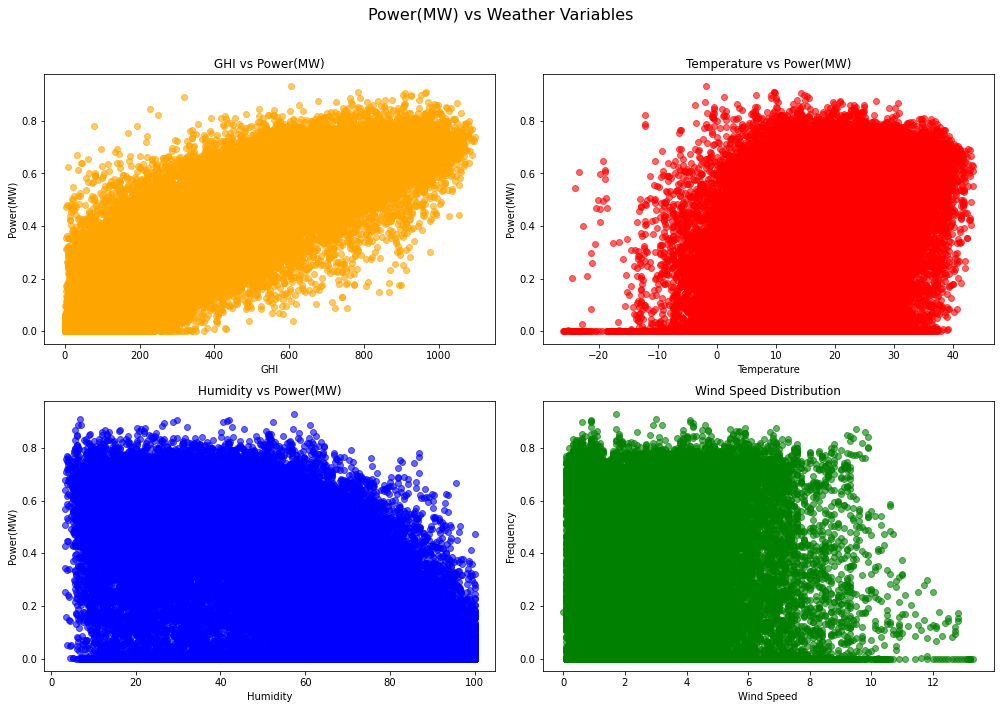

In [54]:
# --- Step 0: Ensure numeric data ---
cols = ['Power(MW)', 'GHI', 'Temperature', 'Relative Humidity', 'Wind Speed']
for col in cols:
    df_power_filtered[col] = pd.to_numeric(df_power_filtered[col], errors='coerce')

# Drop rows with NaN in any of the selected columns
df_power_filtered = df_power_filtered.dropna(subset=cols)

# --- Step 1: Create a 2x2 grid of plots ---
fig, axs = plt.subplots(2, 2, figsize=(14,10))
fig.suptitle('Power(MW) vs Weather Variables', fontsize=16)

# 1️⃣ Scatter plot: GHI vs Power(MW)
axs[0,0].scatter(df_power_filtered['GHI'], df_power_filtered['Power(MW)'], color='orange', alpha=0.6)
axs[0,0].set_xlabel('GHI')
axs[0,0].set_ylabel('Power(MW)')
axs[0,0].set_title('GHI vs Power(MW)')

# 2️⃣ Scatter plot: Temperature vs Power(MW)
axs[0,1].scatter(df_power_filtered['Temperature'], df_power_filtered['Power(MW)'], color='red', alpha=0.6)
axs[0,1].set_xlabel('Temperature')
axs[0,1].set_ylabel('Power(MW)')
axs[0,1].set_title('Temperature vs Power(MW)')

# 3️⃣ Scatter plot: Humidity vs Power(MW)
axs[1,0].scatter(df_power_filtered['Relative Humidity'], df_power_filtered['Power(MW)'], color='blue', alpha=0.6)
axs[1,0].set_xlabel('Humidity')
axs[1,0].set_ylabel('Power(MW)')
axs[1,0].set_title('Humidity vs Power(MW)')

# 4️⃣ Histogram: Wind Speed distribution
axs[1,1].scatter(df_power_filtered['Wind Speed'], df_power_filtered['Power(MW)'], color='green', alpha=0.6)
axs[1,1].set_xlabel('Wind Speed')
axs[1,1].set_ylabel('Frequency')
axs[1,1].set_title('Wind Speed Distribution')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [49]:
# Correlation Analysis

# Compute correlation matrix
corr_matrix = df_power_filtered.corr()

# Get absolute correlation with Power(MW), sort descending
top_features = corr_matrix['Power(MW)'].abs().sort_values(ascending=False)

top_8_features = top_features.drop('Power(MW)')
print(top_8_features)

GHI                   0.920007
DNI                   0.839974
Solar Zenith Angle    0.781637
DHI                   0.603850
Relative Humidity     0.511062
Temperature           0.400908
Cloud Type            0.238856
Wind Speed            0.223073
Name: Power(MW), dtype: float64


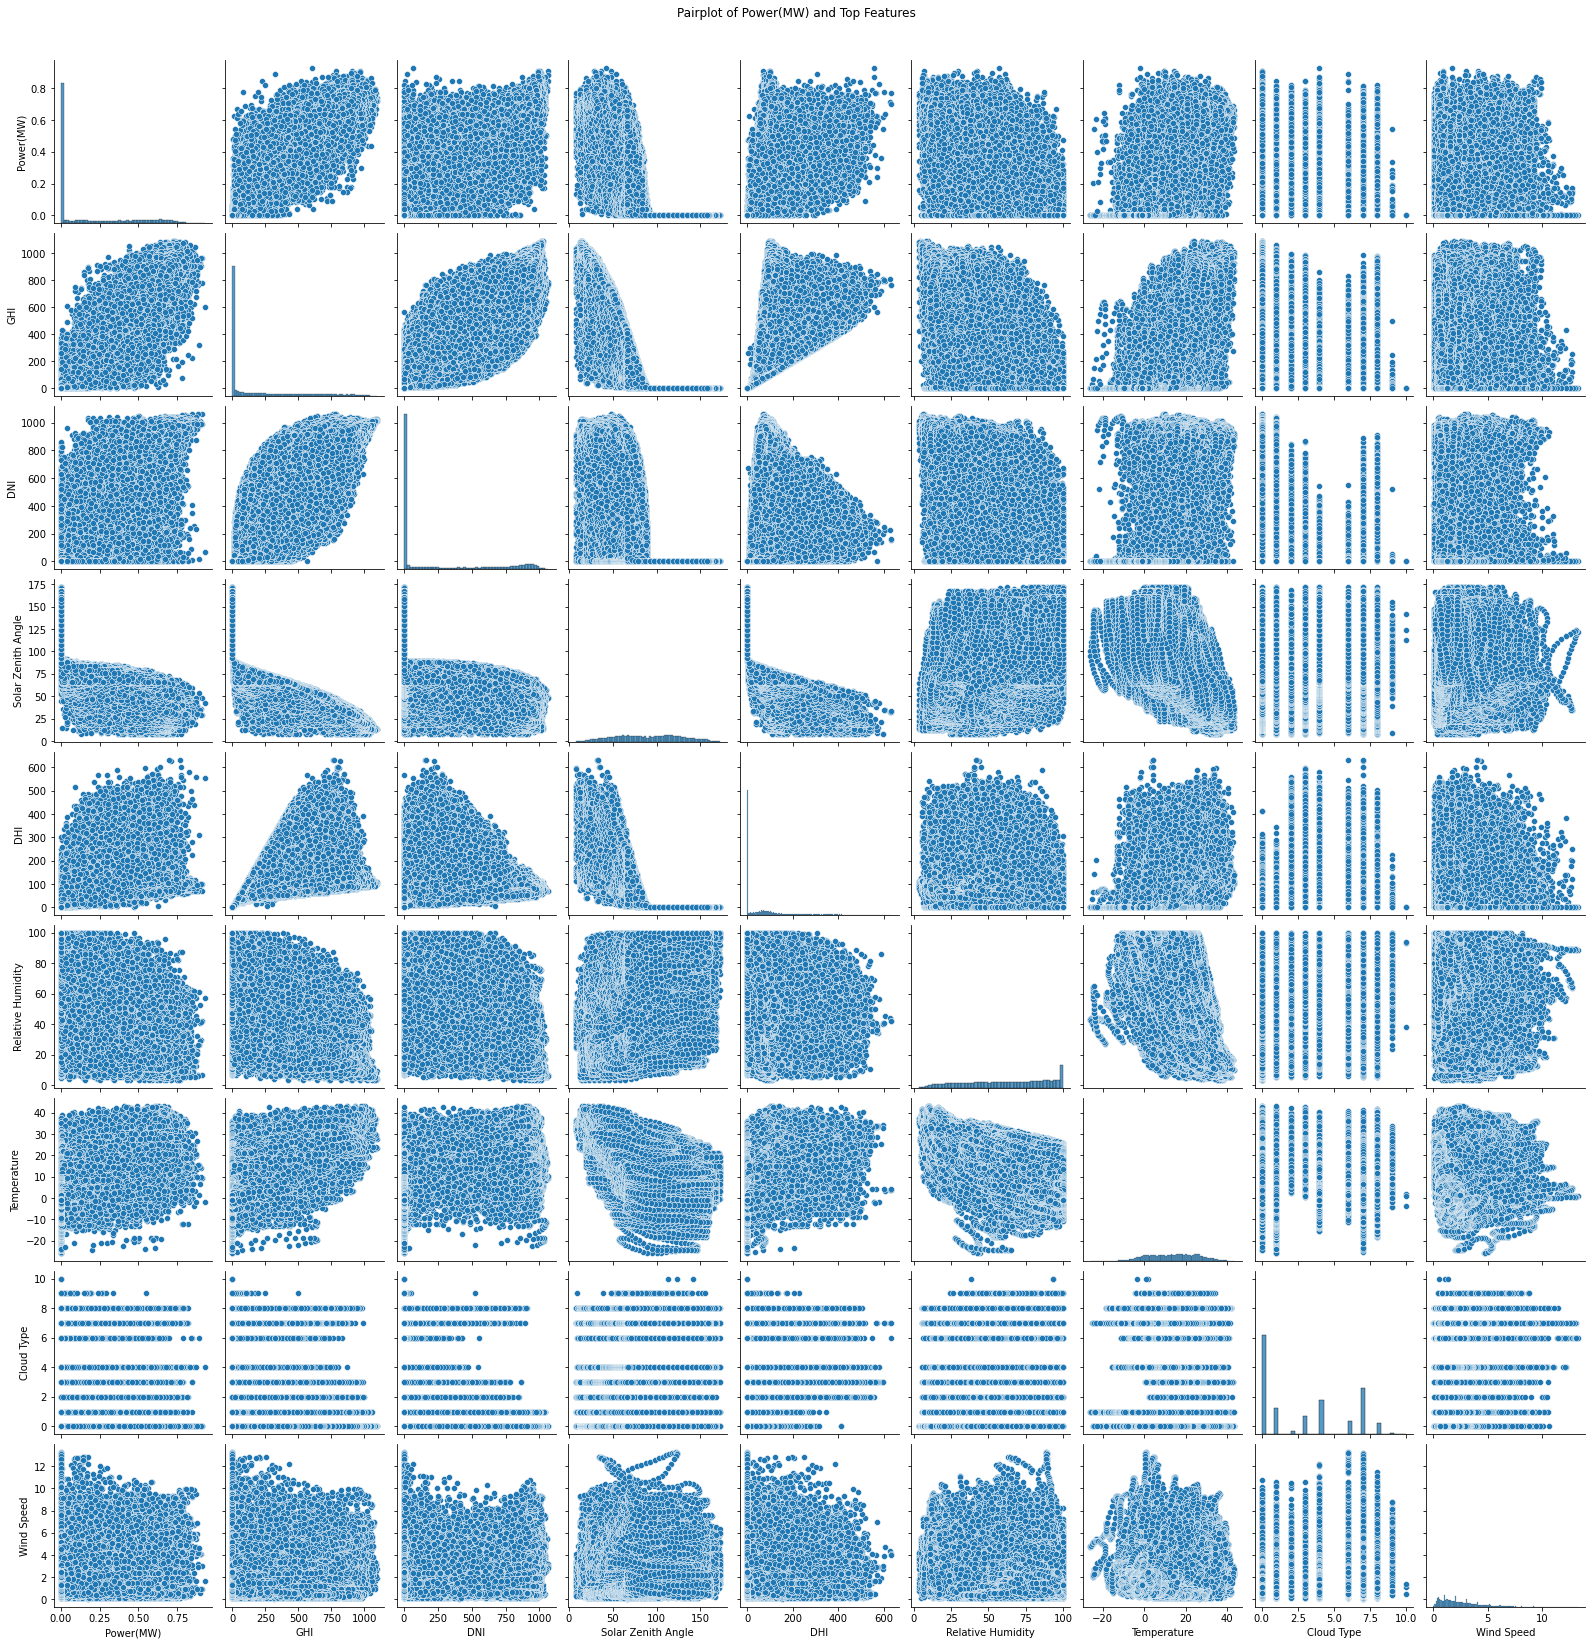

In [ ]:

# Select columns: Power(MW) + top 8 features
pairplot_cols = ['Power(MW)'] + top_8_features.index.tolist()
df_pairplot = df_power_filtered[pairplot_cols]

# Create pairplot
sns.pairplot(df_pairplot)
plt.suptitle('Pairplot of Power(MW) and Top Features', y=1.02)
plt.show()

In [57]:
df_power_filtered.isnull().sum()

df_features =df_power_filtered.drop(['LocalTime'], axis=1)

df_features.head()

,Power(MW),DNI,DHI,GHI,Relative Humidity,Solar Zenith Angle,Cloud Type,Temperature,Wind Speed
0,0.0,0,0,0,100.0,172.12,1,15.0,1.5
1,0.0,0,0,0,100.0,168.33,1,14.9,1.5
2,0.0,0,0,0,100.0,162.69,1,14.8,1.5
3,0.0,0,0,0,100.0,156.52,1,14.7,1.6
4,0.0,0,0,0,100.0,150.16,1,14.6,1.6


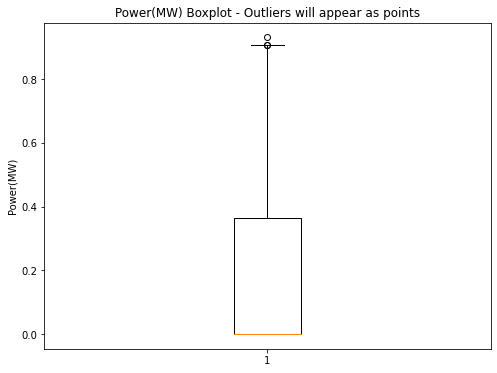

In [58]:
# Outliers detection
plt.figure(figsize=(8,6))
plt.boxplot(df_features['Power(MW)'], vert=True)
plt.title('Power(MW) Boxplot - Outliers will appear as points')
plt.ylabel('Power(MW)')
plt.show()

In [60]:
# Feature and Target Separation
X = df_features.drop('Power(MW)', axis=1)
y = df_features['Power(MW)']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization or feature scaling, don't do it on the whole dataset, it can create problems, your model will see the test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
# Create model instance
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Examine the trained model coefficients:

print("Model Coefficients:")
print(f"Intercept: {model.intercept_:.4f}")
print("\nFeature Coefficients:")
for feature, coef in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")


Model Coefficients:
Intercept: 0.1782

Feature Coefficients:
DNI: 0.0810
DHI: 0.0383
GHI: 0.1281
Relative Humidity: -0.0004
Solar Zenith Angle: -0.0168
Cloud Type: -0.0020
Temperature: -0.0163
Wind Speed: 0.0078


In [69]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# performance matrics
r2score = model.score(X_test_scaled, y_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("MODEL PERFORMANCE METRICS:")
print("="*30)
print(f"R² Score: {r2score:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Root mean squared  error: {rmse:.4f} MW")
print(f"Average prediction error: {mae:.4f} MW")

MODEL PERFORMANCE METRICS:
R² Score: 0.8724
R² Score: 0.8724
Root mean squared  error: 0.0890 MW
Average prediction error: 0.0555 MW


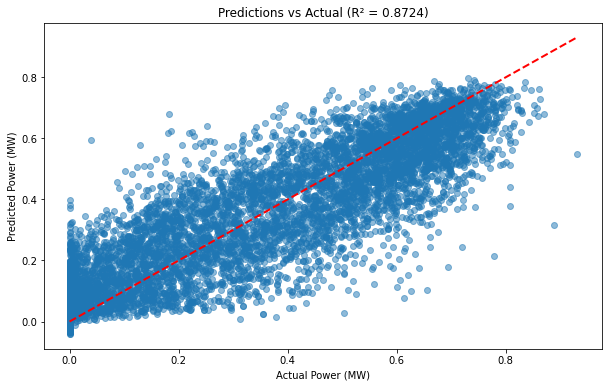

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Power (MW)')
plt.ylabel('Predicted Power (MW)')
plt.title(f'Predictions vs Actual (R² = {r2:.4f})')
plt.show()

In [ ]:
# Fine Tuning using Ridge regression by changing regularizatio parameter alpha

from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params, cv=5, scoring='r2')
grid.fit(X_train_scaled, y_train)

print("Best alpha:", grid.best_params_)
print("Best R2:", grid.best_score_) # It comes from cross-validation of training data, the training_date is split into training and test sets

y_pred = grid.predict(X_test_scaled)
print("R2:", r2_score(y_test, y_pred))  # This score comes after applying model on test test
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))




Best alpha: {'alpha': 1}
Best R2: 0.8717455495603458
R2: 0.8724105542403784
RMSE: 0.08895690157490091
